<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A1%D0%BE%D1%80%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%BA%D0%BE%D0%BD%D1%82%D1%83%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сортировка контуров

# Sorting contours


В этом уроке мы научимся сортировать контуры

In this lesson we will learn how to sort contours


Сортировка контуров является тоже важным аспектом в различных проектах обработки изображения. Например, когда мы создаем систему распознавания автомобильных номеров, нам нужно будет не только найти контуры каждого символа на номерном знаке, но и  отсортировать  контуры символов слева направо, чтобы мы могли правильно прочитать конечных результат. 

Contour sorting is also an important aspect in various image processing projects. For example, when we create a license plate recognition system, we will need not only to find the contours of each symbol on the license plate, but also to sort the contours of the symbols from left to right, so that we can read the final result correctly.

Для этого мы будем вычислять область ограничивающего прямоугольника, а затем сортировать их в удобном для нас представлении.



 


To do this, we will calculate the area of the bounding rectangle and then sort them in a convenient representation.

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_31.Sorting_contours.zip
!unzip Lesson_31.Sorting_contours.zip
%cd /content/Lesson_31.Sorting_contours

--2022-02-03 18:48:44--  http://dataudt.ru/datasets/cv/Lesson_31.Sorting_contours.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447869 (437K) [application/zip]
Saving to: ‘Lesson_31.Sorting_contours.zip’

Lesson_31.Sorting_c 100%[===================>] 437.37K   522KB/s    in 0.8s    

2022-02-03 18:48:45 (522 KB/s) - ‘Lesson_31.Sorting_contours.zip’ saved [447869/447869]

Archive:  Lesson_31.Sorting_contours.zip
  inflating: Lesson_31.Sorting_contours/lego_01.png  
  inflating: Lesson_31.Sorting_contours/lego_02.png  
  inflating: Lesson_31.Sorting_contours/lego_03.png  
  inflating: Lesson_31.Sorting_contours/Sorting_contours.py  
/content/Lesson_31.Sorting_contours


In [2]:
# импортируем необходимые модули
# import the necessary packages
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow

In [3]:
def sort_contours(cnts, method="left-to-right"):
    # инициализируем обратный флаг и индекс сортировки
    # initialize the reverse flag and sort index
	reverse = False
    # указывает по x или y
    # points by x or y
	i = 0 

    # обработать, если нам нужно 
    # отсортировать в обратном порядке
    # handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True

    # обрабатываем, если мы сортируем по координате y, 
    # а не по координате x ограничивающего прямоугольника
    # handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1

    # построем список ограничивающих рамок 
    # и отсортируем их сверху вниз
    # construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))

    # возвращаем список отсортированных контуров
    # и ограничивающих рамок
    # return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [4]:
def draw_contour(image, c, i):
    # вычисляем центр области контура 
    # и рисуем круг, представляющий центр
    # compute the center of the contour area and draw a circle
	# representing the center
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])

    # рисуем номер контура на изображении
    # draw the countour number on the image
	cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
		1.0, (255, 255, 255), 2)

    # возвращаем изображение 
    # с нарисованным на нем номером контура
    # return the image with the contour number drawn on it
	return image

In [7]:
# создаем отдельный словарь с аргументами 
# create a separate dictionary with arguments 
args = {
'image':'lego_01.png',
# метод сортировки
# sorting method
'method':"top-to-bottom" 
}

Оборачиваем все наши последующие действия в функцию, чтобы потом быстро воспроизведи все результаты на других примерах

Wrap all of our next steps in a function, so that we can quickly reproduce the results on other examples

Edge Map


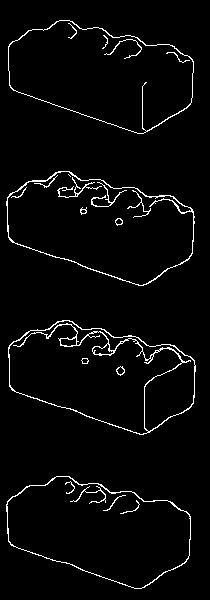

In [8]:
def edge_map(args):
    # и инициализируем накопленное краевое изображение
    # load the image and initialize the accumulated edge image
    # загружаем изображение 
    image = cv2.imread(args["image"])
    accumEdged = np.zeros(image.shape[:2], dtype="uint8")
    # перебираем синий, зеленый и красный каналы соответственно
    # loop over the blue, green, and red channels, respectively
    for chan in cv2.split(image):
        # размываем канал, извлекаем из него края 
        # и накапливаем набор краев для изображения
        # blur the channel, extract edges from it, and accumulate the set
        # of edges for the image
        chan = cv2.medianBlur(chan, 11)
        edged = cv2.Canny(chan, 50, 200)
        accumEdged = cv2.bitwise_or(accumEdged, edged)

    # отобразим накопленную карту границ
    # show the accumulated edge map
    print("Edge Map") 
    cv2_imshow(accumEdged)
    return image, accumEdged
image, accumEdged = edge_map(args)

Unsorted


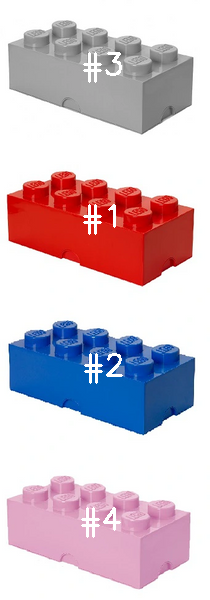

In [9]:
def unsorted_contour(image, accumEdged):
    # находим контуры в накопленном изображении,
    # оставляя только самые большие
    # find contours in the accumulated image, keeping only the largest
    # ones
    cnts= cv2.findContours(accumEdged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # сортируем по площади,
    # но не по порядку на изображении
    # чтобы отсеять маленькие контуры
    # sort by area,
    # but not in order in the image
    # to weed out small outlines
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    orig = image.copy()

    # перебираем (несортированные) контуры и нарисуем их
    # loop over the (unsorted) contours and draw them
    for (i, c) in enumerate(cnts):
        orig = draw_contour(orig, c, i)

    # покажем исходное несортированное 
    # изображение с контурами
    # show the original, unsorted contour image
    print("Unsorted") 
    cv2_imshow(orig)
    return cnts

cnts = unsorted_contour(image, accumEdged)

Sorted


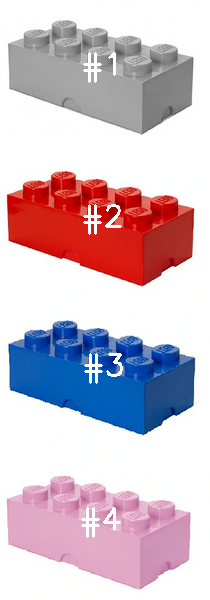

In [10]:

def sorted_contour(args,cnts,image):
    # сортируем контуры согласно предоставленному методу
    # sort the contours according to the provided method
    (cnts, boundingBoxes) = sort_contours(cnts, method=args["method"])

    # обведём (теперь отсортированные) контуры и нарисуем их
    # loop over the (now sorted) contours and draw them
    for (i, c) in enumerate(cnts):
        draw_contour(image, c, i)

    # покажем выходное изображение
    # show the output image
    print("Sorted") 
    cv2_imshow(image)


sorted_contour(args,cnts,image)

Это мы посмотрели работу сортировки по вертикали сверху вниз. Попробуем применить другие методы сортировки на новых изображениях. Для этого проделаем тоже самое, но для сортировки по горизонтали слева направо.

We have seen how sorting vertically from top to bottom works. Let's try to apply other sorting methods to new images. To do this, let's do the same thing, but to sort horizontally from left to right.

In [11]:
# инициализируем еще раз наш словарь с аргументами, но уже с другими настройками
# let's initialize our dictionary again with arguments, but with different settings 
args2 = {
'image':'lego_02.png',
# метод сортировки
# sorting method
'method':"left-to-right" 
}

Edge Map


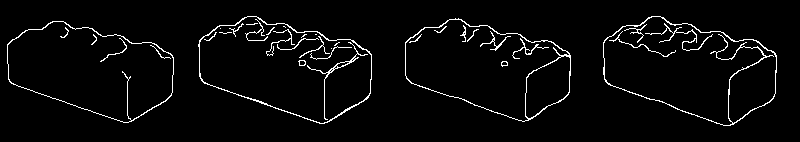

In [12]:
image2, accumEdged2 = edge_map(args2)

Unsorted


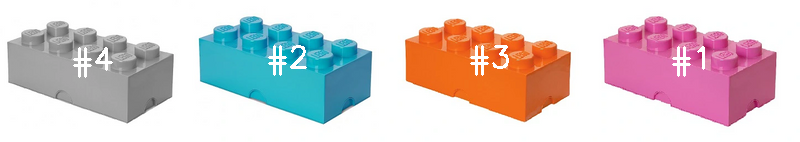

In [13]:
cnts2 = unsorted_contour(image2, accumEdged2)

Sorted


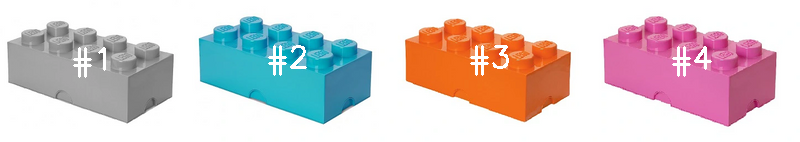

In [14]:
sorted_contour(args2,cnts2,image2)

И еще раз посмотрим результаты, но уже для общей сортировки. 

And once again let's look at the results, but for general sorting. 


In [15]:
# инициализируем еще раз наш словарь с аргументами, но уже с другими настройками
# let's initialize our dictionary again with arguments, but with different settings 
args3 = {
'image':'lego_03.png',
# метод сортировки
# sorting method
'method':"top-to-bottom" 
}

Edge Map


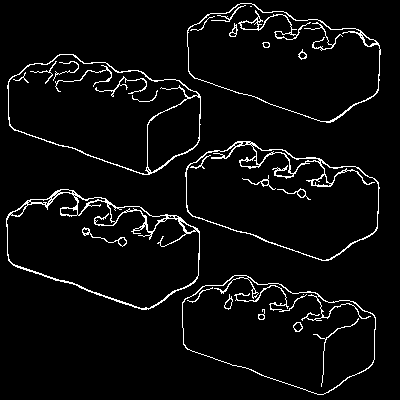

In [16]:
image3, accumEdged3 = edge_map(args3)

Unsorted


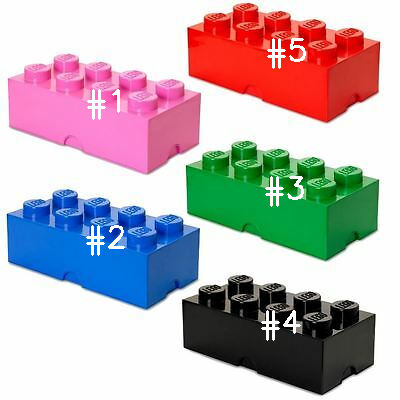

In [17]:
cnts3 = unsorted_contour(image3, accumEdged3)

Sorted


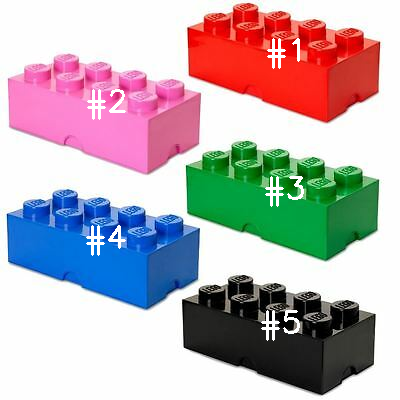

In [18]:
sorted_contour(args3,cnts3,image3)